In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Load data

In [3]:
train_set = pd.read_csv('training.csv') 
test_set  = pd.read_csv('testing.csv')

# Data exploration

In [4]:
def missing_zero_values_table(df):
    """
    Parameters:
        df: dataframe to use
    
    Returns:
        mz_table: table with a count of blank values and missing values 
                    and these values as percentage of the total
    """
    no_val = (df == ' ').astype(int).sum(axis=0)
    zero_val = ((df == 0.00).astype(int).sum(axis=0) / len(df)) * 100 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([no_val, mis_val, zero_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(columns = {0 : 'Blank Values', 1 : 'Missing Values',
                                          2 : '% Zero Values', 3 : '% of Total Values'})
    mz_table = mz_table.sort_values('% of Total Values', ascending=False).round(1)

    return mz_table

In [30]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   city       2000 non-null   object
 1   website    2000 non-null   object
 2   employees  2000 non-null   object
 3   status     2000 non-null   object
 4   value      2000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 78.2+ KB


In [21]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   city       2000 non-null   object
 1   website    2000 non-null   object
 2   employees  2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [71]:
missing_zero_values_table(train_set)

,Blank Values,Missing Values,% Zero Values,% of Total Values
city,0,0,0.0,0.0
website,0,0,0.0,0.0
employees,0,0,0.0,0.0
status,0,0,0.0,0.0
value,0,0,90.0,0.0


In [59]:
missing_zero_values_table(test_set)

,Blank Values,Missing Values,Zero Values,% of Total Values
city,0,0,0,0.0
website,0,0,0,0.0
employees,0,0,0,0.0


# EDA

I assume the *value* column is the target feature. 

In [5]:
def make_barplot(df, var_group, var_agg, aggregation, rot = False):
    '''
    Parameters: 
        df : df to use
        var_gr : feature used to group 
        var_agg: feature used to create the aggregation needed
        aggregation : aggregation to use to aggregate var_agg
        rot : False if X axis should not be rotated 
    
    Returns : 
        barchart mean of var_group by var_mn
    '''
    # Grouping to plot
    df_gr = df.groupby([var_group], as_index=False)[var_agg].agg(aggregation)

    # Gráfico
    sns.set_style("white")
    plt.figure(figsize=(12,8))
    sns.set_context("paper", font_scale=1.5)
    
    plot = sns.barplot(x=var_group, y=var_agg, data=df_gr, palette="Set3")
    if rot : 
        for item in plot.get_xticklabels():
            item.set_rotation(90)
    plt.show()

## Univariate

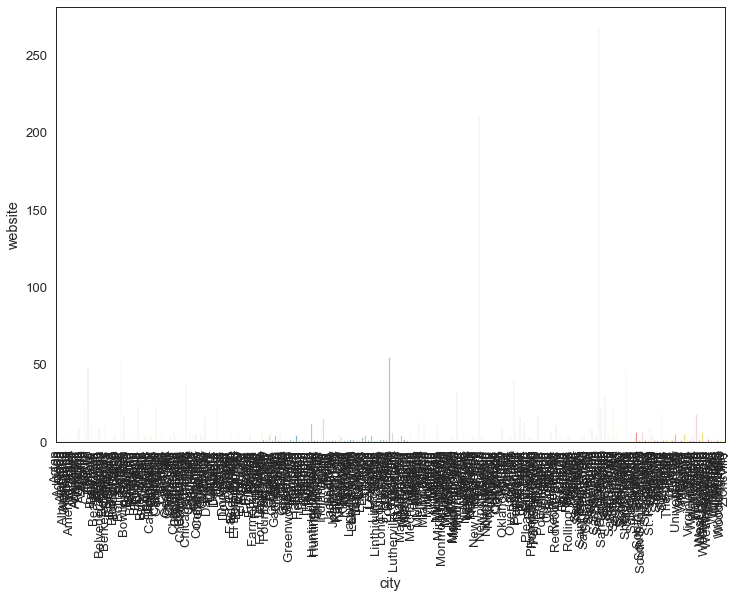

In [16]:
make_barplot(train_set, 'city', 'website', 'count', rot=True)

There are too many cities for this to be considered as a feature. If this were to be included as a predictive feature to get the value, it would definitely overfit. <br>
One alternative could be to get the states and use the feature at a state level. 

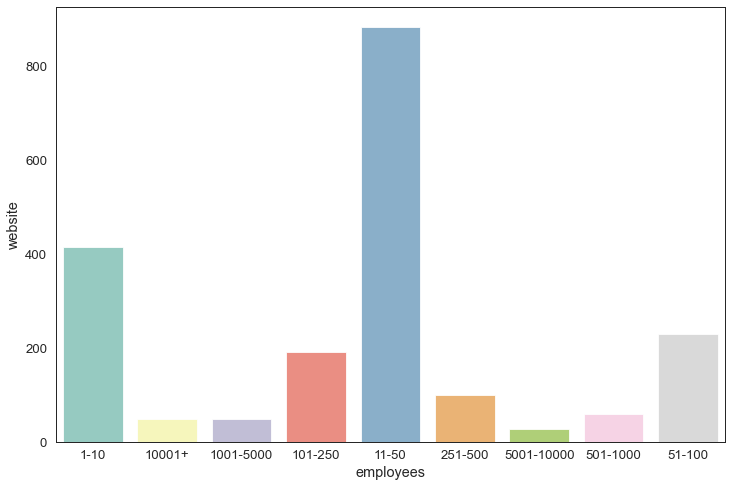

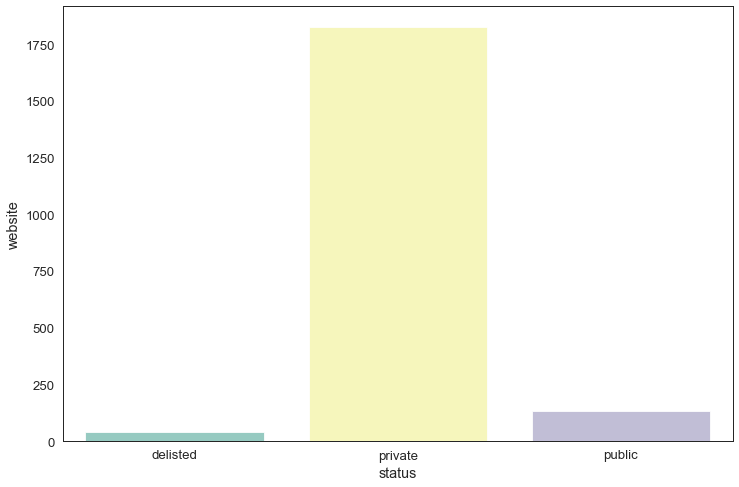

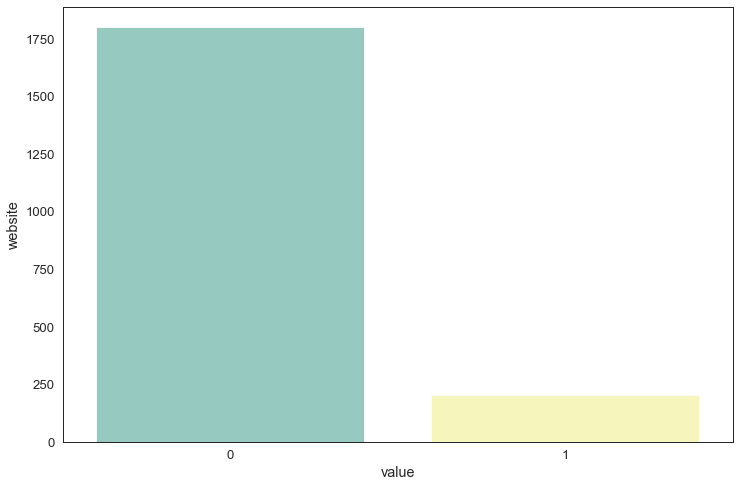

In [14]:
cols = ['employees', 'status', 'value']
for col in cols: 
    make_barplot(train_set, col, 'website', 'count')

## Bivariate

In [17]:
def pct_bar_labels(ax1):
    plt.ylabel('Relative Frequency (%)')
    plt.xticks(rotation = 0)
    plt.yticks([])   
    # Set individual bar lebels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha = 'center', va = 'center', xytext = (0, 7), 
        textcoords = 'offset points', fontsize = 10, color = 'black')

def composition(cat, cat_target): 
    """
    Parameters: 
        cat: categorical feature to plot
        cat_target: target feature
        
    Returns: 
        plot with % of observations by category, according to target value
    """
    pct_cat_grouped_by_cat_target = round(pd.crosstab(index = cat, 
                                                      columns = cat_target, 
                                                      normalize = 'index')*100, 2)
    pct_cat_grouped_by_cat_target.sort_values(by=1.0, inplace=True)
    
    # Plot relative freq of target by a categorical variable
    sns.set(rc={'figure.figsize':(15,6)})
    
    ax1 = pct_cat_grouped_by_cat_target.plot.bar(color = ['#E74C3C', '#76D7C4'])
    plt.title('Percentage target by %s' %cat.name)
    pct_bar_labels(ax1)
    plt.show()

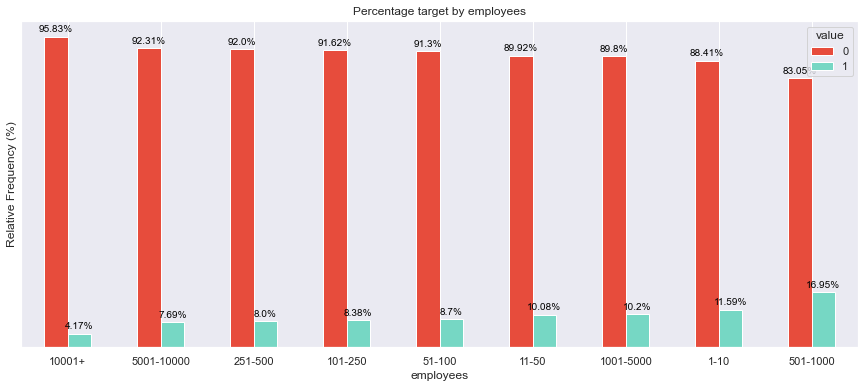

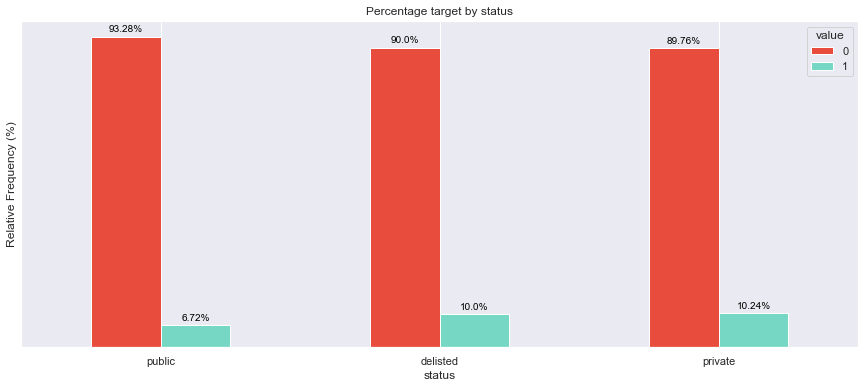

In [20]:
var_list = ['employees', 'status']
for var in var_list:
    composition(train_set[var], train_set['value'])

The number of employees seems to have a clear relationship with the value column. 